In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from itertools import combinations

import xgboost as xgb
from xgboost import XGBClassifier

# Suppress FutureWarning and RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
study_dir = './study'
data_dir = f'{study_dir}/data'
extract_dir = f'{study_dir}/extracted'
pooled_data = f'{study_dir}/pooled_data'

## Extract all Essential Data

In [3]:
# this cell performs the extraction of all the required files for the patinets from the 'pooled_data'
# It performs an etraction of data only regarding the 'Baseline' for each patient
# extra columns from the dataframes are droppped, these do not have any relevance to the XGB model
# ex. 'Start_date', 'Stop_date', 'Percentage_reduction' etc.

df_dem = pd.read_excel(f"{pooled_data}/demographics.xlsx", index_col=0) 
df_med = pd.read_excel(f"{pooled_data}/medication.xlsx", index_col=0) 
df_med_bsl = df_med[df_med['No.'].notna()]
df_med_bsl.to_excel('output_file.xlsx', index=1)

df_dep = pd.read_excel(f"{pooled_data}/nddie_corrected.xlsx", index_col=0)
df_dep_bsl  = df_dep[df_dep['timepoint'] == 'bsl']
df_dep_bsl = df_dep_bsl.drop(columns=['timepoint'])

df_cog = pd.read_excel(f"{pooled_data}/neurocognition.xlsx", index_col=0) 
df_cog_bsl  = df_cog[df_cog['timepoint'] == 'bsl']
df_cog_bsl = df_cog_bsl.drop(columns=['timepoint', 'nc_score_age_corrected_diff_bsl', 
                                      'change_compared_to_bsl', 'nc_score_diff_bsl'])

df_sez = pd.read_excel(f"{pooled_data}/seizure_frequency.xlsx", index_col=0) 
df_sez_bsl  = df_sez[df_sez['timepoint'] == 'bsl']
df_sez_bsl = df_sez_bsl.drop(columns=['timepoint', 'start_date', 'stop_date', 'diff_to_bsl', 'perc_reduction_to_bsl', 'aed_given'])


df_qol = pd.read_excel(f"{pooled_data}/qolie.xlsx", index_col=0) 
df_qol_bsl  = df_qol[df_qol['timepoint'] == 'bsl']
filtered_columns = [col for col in df_qol_bsl.columns if 'diff' not in col]
df_qol_bsl = df_qol_bsl[filtered_columns]
df_qol_bsl = df_qol_bsl.drop('timepoint', axis=1)

In [4]:
# we perform the merging of all the required files in this cell
# the 'weight' and 'height' columns are used to calculate 'BMI' and then they are dropped
# The final features that are present are :
# 'Age' 'Gender' 'Depression Score' 'Neurocognition score' 'Number of Seizures' 'QOL score' 'BMI'
df_merged = pd.merge(df_dem, df_dep_bsl, on='subject_id')
df_merged = pd.merge(df_merged, df_cog_bsl, on='subject_id')
df_merged = pd.merge(df_merged, df_sez_bsl, on='subject_id')
df_merged = pd.merge(df_merged, df_qol_bsl, on='subject_id')
df_merged = df_merged.sort_values('subject_id')
df_merged['gender'] = df_merged['gender'].replace({'Male': 1, 'Female': 0})

df_merged = df_merged.fillna(0)

df_merged['bmi'] = df_merged['weight'] / ((df_merged['height'] / 100) ** 2)
df_merged = df_merged.drop(columns=['height', 'weight'])

df_merged = df_merged.drop(columns=['score_a_energy', 'score_b_mood','nc_score_age_corrected', 'score_c_daily_activities','score_g_overall_qol', 'score_d_cognition','score_f_seizure_worry', 'score_e_medication_effects' ])

df_merged

,age,gender,dep_score,nc_score,n_seizures,qolie_score,bmi
subject_id,,,,,,,
a,31,1,13,20.0,117.0,44.9,31.523259
a0,41,0,11,30.0,4.0,53.3,35.830178
b,23,0,6,33.0,24.0,79.1,22.405877
b0,52,0,17,16.0,11.0,39.8,24.056935
c,28,1,15,28.0,6.0,74.9,22.857143
c0,24,0,6,27.0,146.0,77.9,36.132335
d,54,1,15,24.0,6.0,40.1,26.573129
d0,25,0,11,35.0,10.0,51.1,21.410945
e,40,1,19,20.0,35.0,40.0,30.514263


In [5]:
# Generate subject_ids that are used for the labels
responders = ['a', 'c', 'i', 'g', 'o', 'j', 'p', 'u', 'w', 'y', 'a0', 'b0', 'c0', 'd0', 'f0', 'g0']
all_subjects = [chr(ord('a') + i) for i in range(26)] + [f'{chr(ord("a") + i)}0' for i in range(8)]

# Create DataFrame of labels
df = pd.DataFrame({'subject_id': all_subjects})

# Assign 1 to responders, 0 to non-responders
df['status'] = np.where(df['subject_id'].isin(responders), 1, 0)
df = df.sort_values('subject_id')

# Final dataframe of labels
df = df.set_index('subject_id')
# drop patient 'k' 
df = df.drop('k', axis=0)

df

,status
subject_id,
a,1
a0,1
b,0
b0,1
c,1
c0,1
d,0
d0,1
e,0


In [6]:
def feature_selection(batch_size):
    """ Feature selection function for selecting the faetures that give the best accuracy w.r.t train and test
    Args 
        batch_size: total number of features to be selected from the entire set ex. '3' out of 7 features
    Returns
        best_features: the features that gave the best accuracy for current batch size
        best_accuracy_train: final training accuracy of the model for current batch size
        best_accuracy_test: final testing accuracy of the model for current batch size
    """
# Initialize variables to store best accuracy and corresponding features
    best_accuracy_train = 0
    best_accuracy_test = 0
    best_features = None
    accuracy_difference = 100

    print('--'*45)
    print('--'*10, f'Feature selection now running with batch Size = {batch_size}', '--'*10)
    print('--'*45)

    # Generate all possible combinations of features
    all_features = df_merged.columns[0:]
    all_feature_combinations = list(combinations(all_features, batch_size))

    # Loop through all combinations of features
    for i, selected_features in enumerate(all_feature_combinations):
        
        # Extract selected features and target variable
        X = df_merged[list(selected_features)]
        y = df['status']
        
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the XGBoost classifier
        classifier = XGBClassifier(n_estimators=128, max_depth=8, learning_rate=0.001, random_state=42)
        model = classifier.fit(X_train, y_train)
        
        # make predictions on training data 
        predictions_train = model.predict(X_train)
        
        # Calculate accuracy on training data
        accuracy_train = accuracy_score(y_train, predictions_train)
        
        # Make predictions on the test set
        predictions_test = model.predict(X_test)
        
        # Calculate accuracy oon test data
        accuracy_test = accuracy_score(y_test, predictions_test)

        # select features only if accuracy difference is less than 0.35 and the testing accuracy is more that 0.6
        # also there are cases where the testing acc is greater than the train. These are 'by chance' so are ignored
        # these values of the conditions can be changed  
        if (accuracy_train - accuracy_test) <= 0.35 and accuracy_test >= 0.6 and accuracy_train > accuracy_test:
            print(f"Iteration {i + 1}:\nSelected Features: {selected_features}\n\nTraining Accuracy - {accuracy_train:.4f}, Testing Accuracy - {accuracy_test:.4f}\n")
        
        # this part of the loop saves the best features, accuracies and also the current smallest difference in the accuracies
            if  (accuracy_train - accuracy_test) < accuracy_difference:
                best_features = list(selected_features)
                accuracy_difference = abs(accuracy_train - accuracy_test)
                best_accuracy_test = accuracy_test
                best_accuracy_train = accuracy_train
        else:
            print(f'Iteration {i + 1}....Accuracy difference too big')

        # this loops makes sure that if none of the features give a good result then the loop is completely ignored
        if (accuracy_train - accuracy_test) == 0 and features == None:
            accuracy_difference = 100

    return best_features, best_accuracy_train, best_accuracy_test, accuracy_difference

In [7]:
def call_feature_selection(batch_size_range):
    """A function used to call the feature selection function for different sets of batch size
    It also compares the difference in the best training and testing accuracy from each batch size and selects the best 
    features as the one with the smallest difference
    
    Args
        batch_size_range: the range of batch size for which you want to run feature selection
    Returns
        final_features: best features among all batch sizes and all possible feature combinations in each batch size
        final_acc_train: best train acc among all batch sizes and all possible feature combinations in each batch size
        final_acc_test: best test acc among all batch sizes and all possible feature combinations in each batch size
    """
    curr_accuracy_diff = 100
    final_features = None
    final_acc_train = 0
    final_acc_test = 0
    # iterate through the range of batch size
    for i in batch_size_range:
        # call the main feature selection with current batch size
        features, best_acc_train, best_acc_test, acc_diff = feature_selection(i)
        print(f'\nBest features and accuracy for batch size {i}: {features}\nAccuracy train = {best_acc_train:.4f}\nAccuracy test = {best_acc_test:.4f}\n')
        # compare the best results from the previous batch size and if the new results are better, save them        
        if acc_diff < curr_accuracy_diff:
            final_features = features
            final_acc_train = best_acc_train
            final_acc_test = best_acc_test
            curr_accuracy_diff = final_acc_train - final_acc_test
    
    return final_features, final_acc_train, final_acc_test  

------------------------------------------------------------------------------------------
-------------------- Feature selection now running with batch Size = 3 --------------------
------------------------------------------------------------------------------------------
Iteration 1....Accuracy difference too big
Iteration 2....Accuracy difference too big
Iteration 3....Accuracy difference too big
Iteration 4....Accuracy difference too big
Iteration 5....Accuracy difference too big
Iteration 6....Accuracy difference too big
Iteration 7....Accuracy difference too big
Iteration 8....Accuracy difference too big
Iteration 9....Accuracy difference too big
Iteration 10....Accuracy difference too big
Iteration 11....Accuracy difference too big
Iteration 12....Accuracy difference too big
Iteration 13....Accuracy difference too big
Iteration 14....Accuracy difference too big
Iteration 15....Accuracy difference too big
Iteration 16....Accuracy difference too big
Iteration 17....Accuracy differ

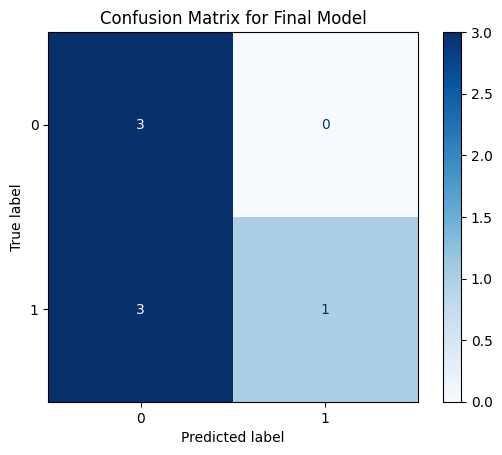

In [8]:
# set the batch size options for feature selection
batch_size_list = [3,4,5]
# call the feature selection fucntion with above batch size options
final_best_features, final_best_acc_train, final_best_acc_test = call_feature_selection(batch_size_list)

# Train the final XGBoost model using the best features
if final_best_features == None:
    print('No acceptable features found...')
else:
    print(f'\nBest features from feature selection algorithm - {final_best_features}')
    X_final = df_merged[list(final_best_features)]
    y = df['status']
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y, test_size=0.2)

    classifier = XGBClassifier(n_estimators=128, max_depth=8, learning_rate=0.01, random_state=42)
    
    model = classifier.fit(X_train_final, y_train_final)
    # Make predictions on the test set
    predictions = model.predict(X_test_final)
    
    accuracy = accuracy_score(y_test_final, predictions)
    print(f"Accuracy: {accuracy*100}%")
    
    cm = confusion_matrix(y_test_final, predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm)
    
    # plot the confusion matrxi
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix for Final Model')
    plt.show()


## Medication Scoring Manual


The medication scoring has been developed in the next section but unfortunately the scoring manual developed 
dosent directly work for the PIMIDES or EASEE study.
It is observed that there are no clear differneces in the scores for the responders and the non-reponders.

The development of a scoring manual for the medication requires a much more complex approach while also considering the
fact about how many medicines each patient takes. 

In [ ]:
def score_medicine(df_meds, df_pats):
    """ Function to perform a scoring of the medicines based on the number of responders sharing it
    Individual score of each medicine = P(Responders) = n(Responders)/n(Responders)+n(non-Responders)
    IF P(Responders) > 0.5:  score * 0.8    :[i.e. at least 50% responders among sharers]
    ELSE:  score * 0.2

    For each patient, overall score = sum of the scores of each of the medicines they take
    Normalisation:
    y = (y/sum)*100
        where, 
        y = total score for a patient
        sum = summation of scores of all patients

    Args
        df_meds (DataFrame): The per medication excel file imported as DF
        df_pats (DataFrame): The per patient excel file imported as DF
        
    Returns
        final_med_score (DataFrame): Individual medicine scores
        final_pat_score (DataFrame): Individual patient scores
        
    """
    data = []
    data_2 = []
    responders = ['a', 'c', 'g', 'i', 'o', 'j', 'p']
   
    
    for med, df in df_meds.items():
        checked_pat = []
        n_resp = n_nonresp = 0
        
        for index, value in df.iterrows():
            if value['Subject_Id'] not in checked_pat:
                checked_pat.append(value['Subject_Id'])
                if value['Subject_Id'] in responders: n_resp += 1
                else: n_nonresp += 1

        med_score = n_resp/(n_resp + n_nonresp)

        # normalisation w.r.t. each medicine
        if med_score > 0.5: med_score = med_score*0.8
        else: med_score = med_score*0.2

        data.append({'Med': med, 'Score': med_score})
    final_med_score = pd.DataFrame(data, columns=['Med', 'Score'])
    
    for pat, subdf in df_pats.items():
        pat_score = 0
        checked_med = [] 
        
        for index, value in subdf.iterrows():
        
            pat_score += final_med_score.loc[final_med_score['Med'] == value['Medication Name'], 'Score'].values[0]
            
        data_2.append({'Pat': pat, 'Score': pat_score})
    final_pat_score = pd.DataFrame(data_2, columns=['Pat', 'Score'])
     
    return final_med_score, final_pat_score


In [ ]:
# Create scores for medicines

df_meds = pd.read_excel(f"{extract_dir}/meds_by_medicine.xlsx", sheet_name=None)
df_pats = pd.read_excel(f"{extract_dir}/meds_by_patient.xlsx", sheet_name=None)

final_med, final_pat = score_medicine(df_meds, df_pats)
dup_df = final_pat

responders = ['a', 'c', 'i', 'g', 'o', 'j', 'p', 'u', 'w', 'y', 'a0', 'b0', 'c0', 'd0', 'f0', 'g0']

# normalisation 
total_score = final_pat['Score'].sum()
for i, row in dup_df.iterrows(): dup_df.at[i, 'Score'] = (row['Score']/total_score)*100


# seperate dfs
subdf_resp = dup_df[dup_df['Pat'].isin(responders)].sort_values(by=['Score'], ignore_index=True)
subdf_non_resp = dup_df[~dup_df['Pat'].isin(responders)].sort_values(by=['Score'], ignore_index=True)

# subdf_resp = subdf_resp

print(f'Final Med DF:\n{final_med}\n\nValue used for normalisation: {total_score}')
print(f'\nFinal responder DF:\n{subdf_resp}\n\nFinal Non-responders DF:\n{subdf_non_resp}')